In [6]:
import matplotlib.pyplot as plt
import random
import numpy as np
import time
from data_utils import get_CIFAR10_data
from data_utils import load_CIFAR10
from data_utils import load_pickle

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'datasets/cifar-10-batches-py'
cifar10_labels_file = 'datasets/cifar-10-batches-py/batches.meta'
label_names = []
with open(cifar10_labels_file, 'rb') as f:
    label_names = load_pickle(f)['label_names']
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print(label_names)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [128]:
# Subsample the data for more efficient code execution in this exercise
num_training = 50000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 10000
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

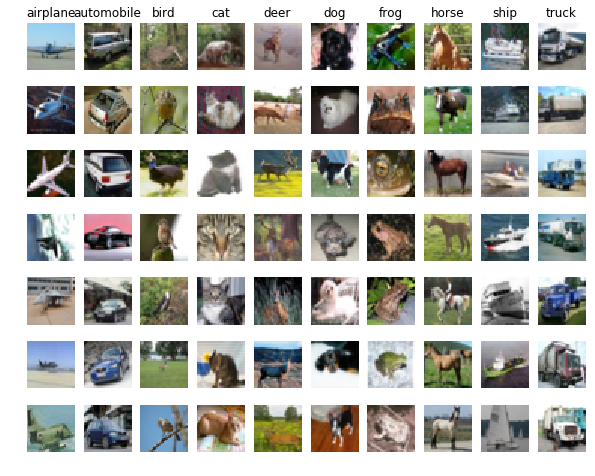

In [70]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
num_classes = len(label_names)
samples_per_class = 7
for y, cls in enumerate(label_names):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

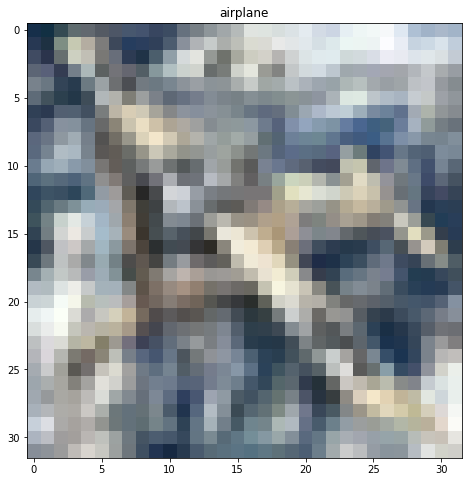

In [127]:
random_idx = np.random.randint(X_train.shape[0])
plt.imshow(X_train[random_idx].astype('uint8'))
plt.title(label_names[y_train[random_idx]])
plt.show()

# Single Layer Softmax

In [106]:
import tensorflow as tf
from single_layer_softmax import single_layer_softmax
# X: input placeholder of shape [Num_examples, FlattenedImageDims]
# y: output placeholder (without applying softmax) of shape [Num_examples, num_classes]
X, y = single_layer_softmax()
sess = tf.Session()

## Train

In [129]:
EPOCHS = 40000
BATCH_SIZE = 50

# Define loss and optimizer
true_y = tf.placeholder(tf.float32, [None, 10])

with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=true_y,
                                                        logits=y)
cross_entropy = tf.reduce_mean(cross_entropy)

with tf.name_scope('adam_optimizer'):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(true_y, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

sess.run(tf.global_variables_initializer())
for i in range(EPOCHS):
    indices = np.random.choice(range(num_training), BATCH_SIZE, replace=False)
    batch_x = X_train[indices].reshape((-1, 32 * 32 * 3))
    batch_y = np.zeros((BATCH_SIZE, num_classes))
    batch_y[range(BATCH_SIZE), y_train[indices]] = 1
    if i % 100 == 0:
        train_accuracy = accuracy.eval(feed_dict={X: batch_x, true_y: batch_y}, session=sess)
        cross_entropy_d = cross_entropy.eval(feed_dict={X: batch_x, true_y: batch_y }, session=sess)
        print('step %d, training accuracy %g, loss: %g' % (i, train_accuracy, cross_entropy_d))
    train_step.run(feed_dict={X: batch_x, true_y: batch_y}, session=sess)

step 0, training accuracy 0.08, loss: 304.19
step 100, training accuracy 0.18, loss: 42.2862
step 200, training accuracy 0.22, loss: 33.7675
step 300, training accuracy 0.3, loss: 24.5549
step 400, training accuracy 0.2, loss: 27.249
step 500, training accuracy 0.36, loss: 21.4862
step 600, training accuracy 0.16, loss: 27.3096
step 700, training accuracy 0.2, loss: 28.5833
step 800, training accuracy 0.32, loss: 25.3233
step 900, training accuracy 0.28, loss: 22.6965
step 1000, training accuracy 0.34, loss: 20.2943
step 1100, training accuracy 0.28, loss: 25.5758
step 1200, training accuracy 0.24, loss: 26.2673
step 1300, training accuracy 0.24, loss: 20.4341
step 1400, training accuracy 0.16, loss: 21.7859
step 1500, training accuracy 0.24, loss: 22.969
step 1600, training accuracy 0.26, loss: 22.1678
step 1700, training accuracy 0.26, loss: 15.174
step 1800, training accuracy 0.32, loss: 20.8454
step 1900, training accuracy 0.16, loss: 17.2827
step 2000, training accuracy 0.18, loss

In [92]:
y_train[[1,2]].shape

(2,)

In [95]:
np.zeros((2,3))

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

## Evaluate

In [132]:
#with tf.Session() as sess:
#sess.run(tf.global_variables_initializer())
out = sess.run(y, feed_dict={X: X_test.reshape(-1, 32 * 32 * 3)})

In [133]:
predicted_labels = np.argmax(out, axis=1)
num_correct_preds = np.sum(predicted_labels == y_test)
print('Correct predictions: %d' % (num_correct_preds))
print('Accuracy: %f' % (num_correct_preds / num_test))

Correct predictions: 2685
Accuracy: 0.268500


0.11600000000000001

## Predict/Infer

In [130]:
#with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
predictions = sess.run(y, feed_dict={X: X_train[random_idx].reshape(-1, 32 * 32 * 3)})

True label: airplane
Prediction: deer


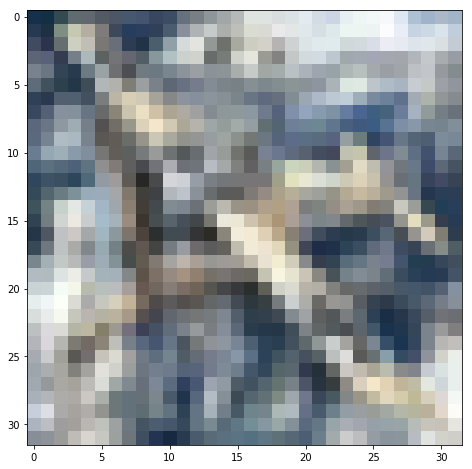

In [131]:
plt.imshow(X_train[random_idx].astype('uint8'))
print('True label: ' + label_names[y_train[random_idx]])
print('Prediction: ' + label_names[np.argmax(predictions)])
plt.show()

In [135]:
sess.close()

In [43]:
import tensorflow as tf
#help(tf.get_variable)
#x = tf.placeholder('float', [None, 10])
x = tf.truncated_normal([100, 10])
help(tf.matmul)

Help on function matmul in module tensorflow.python.ops.math_ops:

matmul(a, b, transpose_a=False, transpose_b=False, adjoint_a=False, adjoint_b=False, a_is_sparse=False, b_is_sparse=False, name=None)
    Multiplies matrix `a` by matrix `b`, producing `a` * `b`.
    
    The inputs must, following any transpositions, be tensors of rank >= 2
    where the inner 2 dimensions specify valid matrix multiplication arguments,
    and any further outer dimensions match.
    
    Both matrices must be of the same type. The supported types are:
    `float16`, `float32`, `float64`, `int32`, `complex64`, `complex128`.
    
    Either matrix can be transposed or adjointed (conjugated and transposed) on
    the fly by setting one of the corresponding flag to `True`. These are `False`
    by default.
    
    If one or both of the matrices contain a lot of zeros, a more efficient
    multiplication algorithm can be used by setting the corresponding
    `a_is_sparse` or `b_is_sparse` flag to `True`. T

In [146]:
from two_layer_softmax import two_layer_softmax
X, y, keep_prob = two_layer_softmax()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [150]:
EPOCHS = 40000
BATCH_SIZE = 50

# Define loss and optimizer
true_y = tf.placeholder(tf.float32, [None, 10])

with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=true_y,
                                                        logits=y)
cross_entropy = tf.reduce_mean(cross_entropy)

with tf.name_scope('adam_optimizer'):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(true_y, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

sess.run(tf.global_variables_initializer())
for i in range(EPOCHS):
    indices = np.random.choice(range(num_training), BATCH_SIZE, replace=False)
    batch_x = X_train[indices].reshape((-1, 32 * 32 * 3))
    batch_y = np.zeros((BATCH_SIZE, num_classes))
    batch_y[range(BATCH_SIZE), y_train[indices]] = 1
    if i % 100 == 0:
        train_accuracy = accuracy.eval(feed_dict={X: batch_x, true_y: batch_y, keep_prob:1.0}, session=sess)
        cross_entropy_d = cross_entropy.eval(feed_dict={X: batch_x, true_y: batch_y, keep_prob:1.0}, session=sess)
        print('step %d, training accuracy %g, loss: %g' % (i, train_accuracy, cross_entropy_d))
    train_step.run(feed_dict={X: batch_x, true_y: batch_y, keep_prob:0.5}, session=sess)

step 0, training accuracy 0.22, loss: 78.294
step 100, training accuracy 0.06, loss: 2.32181
step 200, training accuracy 0.1, loss: 2.3027
step 300, training accuracy 0.04, loss: 2.30281
step 400, training accuracy 0.04, loss: 2.30283
step 500, training accuracy 0.08, loss: 2.30259
step 600, training accuracy 0.08, loss: 2.30262
step 700, training accuracy 0.1, loss: 2.30259
step 800, training accuracy 0.08, loss: 2.30297
step 900, training accuracy 0.16, loss: 2.30223
step 1000, training accuracy 0.18, loss: 2.30188
step 1100, training accuracy 0.06, loss: 2.30291
step 1200, training accuracy 0.12, loss: 2.30236
step 1300, training accuracy 0.12, loss: 2.26875
step 1400, training accuracy 0.14, loss: 2.3023
step 1500, training accuracy 0.18, loss: 2.30208
step 1600, training accuracy 0.08, loss: 2.30241
step 1700, training accuracy 0.02, loss: 2.30329
step 1800, training accuracy 0.08, loss: 2.30263
step 1900, training accuracy 0.06, loss: 2.3032
step 2000, training accuracy 0.06, los

In [153]:
out = sess.run(y, feed_dict={X: X_test.reshape(-1, 32 * 32 * 3), keep_prob:1.0})

In [154]:
predicted_labels = np.argmax(out, axis=1)
num_correct_preds = np.sum(predicted_labels == y_test)
print('Correct predictions: %d' % (num_correct_preds))
print('Accuracy: %f' % (num_correct_preds / num_test))

Correct predictions: 999
Accuracy: 0.099900


In [151]:
predictions = sess.run(y, feed_dict={X: X_train[random_idx].reshape(-1, 32 * 32 * 3), keep_prob:1.0})

True label: airplane
Prediction: horse


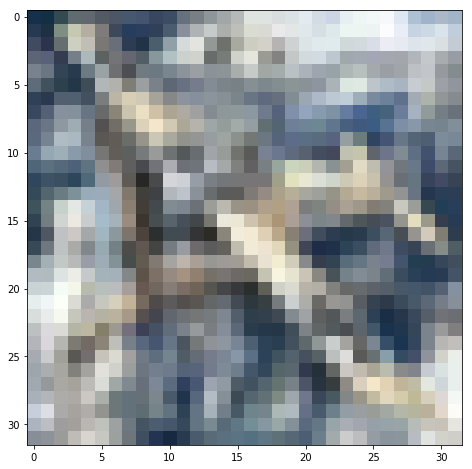

In [152]:
plt.imshow(X_train[random_idx].astype('uint8'))
print('True label: ' + label_names[y_train[random_idx]])
print('Prediction: ' + label_names[np.argmax(predictions)])
plt.show()

In [144]:
sess.close()